## Parallel Quanvolution - NVidia, JAX, AWS 

### Task

Usually - QML algorithms initialize multiple calls to Quantum Circuits.

For particular algorithms - such calls can be parallelized.

For example - famous Quanvolution, clearley explained in Pennylane tutorial:

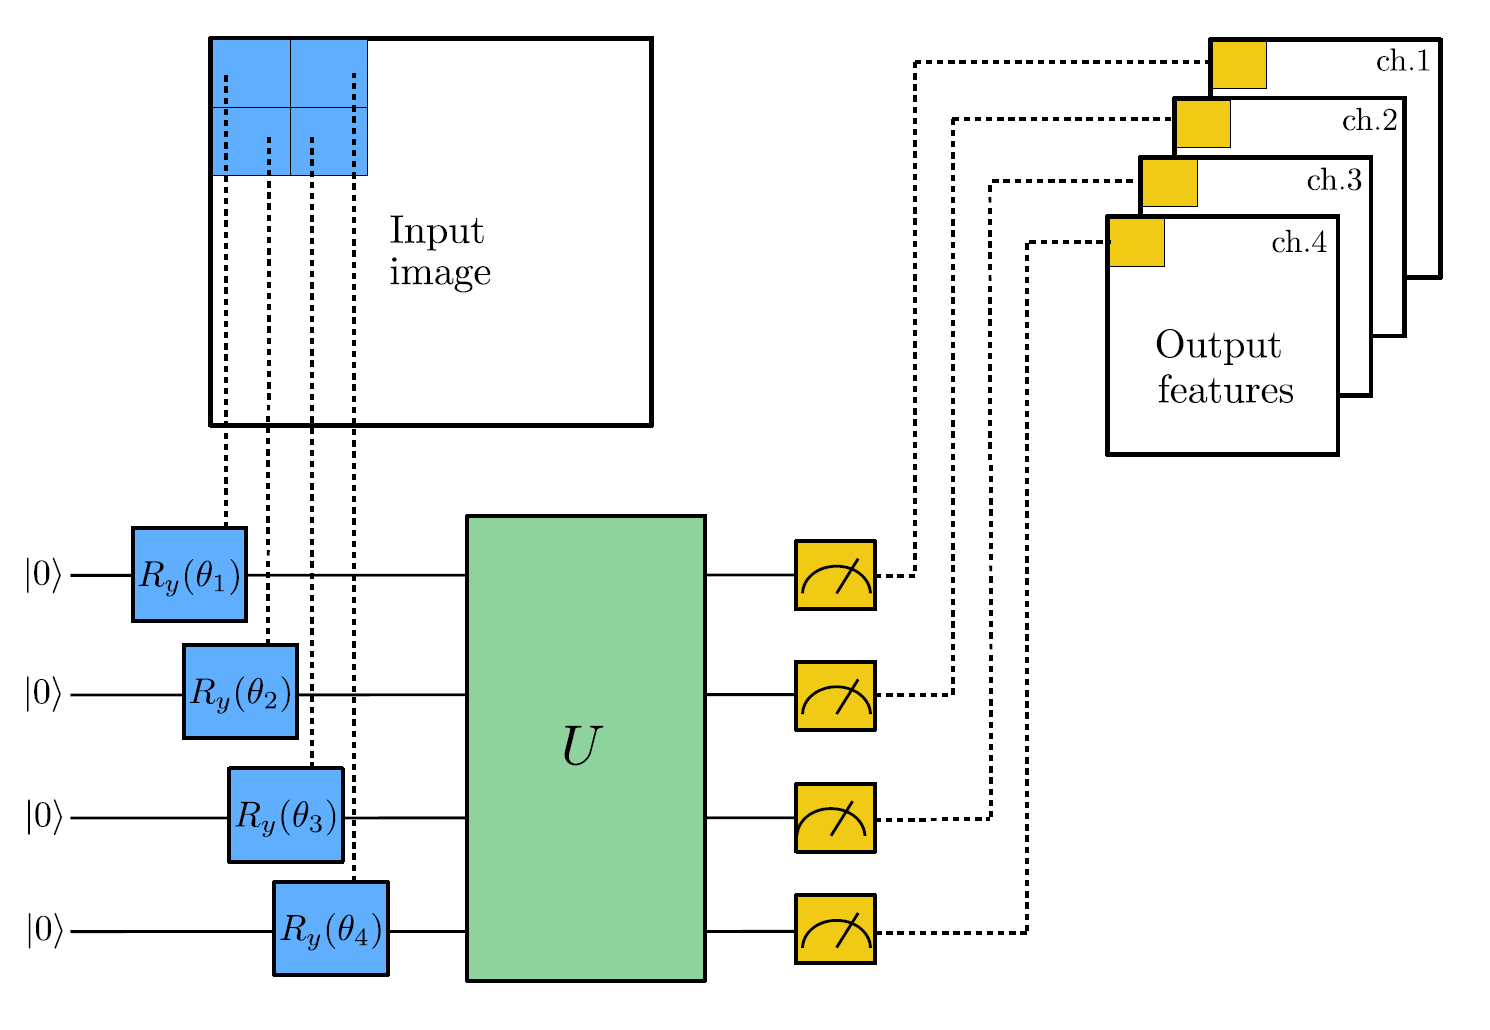

https://pennylane.ai/qml/demos/tutorial_quanvolution.html

As we can see - Filter Quantum Circuits can be applied to input image 100s and 1000s of times during one forward pass.

So we have asked ourseves - **how can we run Quanvolution in parallel?)**



### Solutions

We decided to try 3 approaches:

1) NVidia PennyLane Lightning GPU
2) Parallel execution with JAX
3) Parallel execution with JAX and AWS SV1 managed Simulator

And used below backends:


* `default.qubit` - basic simulator

* `lightning.qubit` - C++ fast simulator

* `lightning.gpu` - GPU-accelerated simulator using NVidia cuQuantum SDK

* `lightning.gpu` - Multi-GPU setup with `batch_obs=True`

* `default.qubit.jax` - for JAX parallelization

* `braket.local.qubit` - AWS local simulator

* `braket.aws.qubit` - to call AWS managed Simulators in parallel)

### Approach 1 - NVidia

Since we were able to access NVidia DGX-2 and DGX A100 - we decided first to utilize power of PennyLane Lightning GPU including multi-GPU execution:

https://pennylane.ai/blog/2022/07/lightning-fast-simulations-with-pennylane-and-the-nvidia-cuquantum-sdk/

In order to utilize `PennLane Lightning GPU` - following stack of Quantum Simulators was launched in Docker Container on remote DGX:

```
Quantum Machine Learning: PennyLane
Quantum Error Mitigation: Qermit, Mitiq
Quantum Frameworks:       Qiskit, Pytket, Cirq, QSim, AWS Braket
ML and Scientific:        PyTorch, TensorFlow, JAX
Remote Access:            Jupyter Enterprise Gateway
NVidia Specific:          cuQuantumSDK, CUDA Toolkit
Based Container:          Docker cuQuantum Appliance
Platform:                 DGX-2, DGX A100
```

Local `Jupyter Notebook` is reaching remote iPython kernel of `Jupyter Enterprise Gateway` in container on DGX via SSH tunnel - so code is easily operated locally, while all computations are made on performant DGX)

### Imports

* `PennyLane` - no explanations needed
* `Tensorflow` - just to import example image like MNIST
* `AWS Braket Cost Tracker` - cost of AWS Braket SV1 second is 0.00375 USD)

In [1]:
import pennylane as qml

from pennylane import numpy as np
from pennylane.templates import RandomLayers

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

import os
import time

from itertools import product
from itertools import combinations_with_replacement

from collections import defaultdict

%run functions.ipynb

TRACK_AWS_BRAKET_COST = False

if TRACK_AWS_BRAKET_COST:    
    from braket.tracking import Tracker

2023-02-27 23:18:24.685936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 23:18:24.781912: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 23:18:24.781931: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-27 23:18:25.289182: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Service functions are at [`functions.ipynb`](functions.ipynb) notebook - with below sections:

* Parameters Processing
* Image Processing
* Quantum
* Parallelization
* Experiments
* Visualization

### JAX

JAX is powerful scientific computing library - and below tutorial gives great explanation of basic usage with PennyLane:

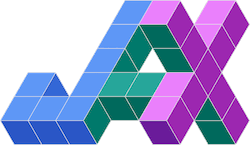

https://pennylane.ai/qml/demos/tutorial_jax_transformations.html

We'll use following features:

* Vectorization (VMap)
* Parallelization (PMap)
* Just-in-time compilation (JIT)



In [2]:
import jax
import jax.numpy as jnp

from jax.config import config

config.update("jax_enable_x64", True)    # to use double-precision numbers

We can use below environment variables to select real GPU CUDA Devices: 

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ", ".join(map(str, range(0, 16)))

Or we can emulate JAX Devices on CPU:

In [4]:
JAX_EMULATED_DEVICES_COUNT = 8

XLA_FLAGS = f"--xla_force_host_platform_device_count={JAX_EMULATED_DEVICES_COUNT}"

os.environ['XLA_FLAGS'] = XLA_FLAGS

jax.devices()

2023-02-27 23:18:30.520106: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-27 23:18:30.520142: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)


[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

To demonstrate Parallel Quanvolution we can use one MNIST image:




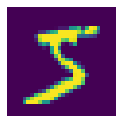

In [5]:
image = load_one_MNIST_image()

# image = image[8:]

plot_image(image)

First - let's try fast `lightning.qubit` with 2x2 filter: 

In [6]:
QML_DEVICE_TYPES = [
    # "default.qubit",
    "lightning.qubit",
    # "lightning.gpu",
    # "lightning.gpu - multi-GPU",
    # "default.qubit.jax",
    # "braket.local.qubit",
    # "braket.aws.qubit"
]

parameters = create_parameters(qml_device_types=QML_DEVICE_TYPES,
                               image_width=28,
                               image_height=28,
                               min_filter_width=2,
                               min_filter_height=2)

Parameters for our experiment are created by `create_parameters` function - which calculated filter applications and strides.

Now we can call `prepare_experiments` to generate all possible combinations:

In [9]:
experiments = prepare_experiments(parameters)

Experiments count: 1


In [10]:
run_experiments(experiments)

Experiment: 1/1
Device: lightning.qubit
Qubits per filter: 4
Filter repetitions: 729
Filter applications: 729
Execution time: 1.17 seconds



Execution time is written to `experiments` - so we can further process and plot it.

Once experimants are executed - they will not be run again:

In [11]:
run_experiments(experiments)

### Variable Filter size

In [12]:
parameters = create_parameters(qml_device_types=["lightning.qubit"],
                               image_width=28,
                               image_height=28,
                               min_filter_width=16,
                               max_filter_width=18,
                               min_filter_height=1)

In [13]:
experiments = prepare_experiments(parameters)

run_experiments(experiments)

Experiments count: 3
Experiment: 1/3
Device: lightning.qubit
Qubits per filter: 16
Filter repetitions: 364
Filter applications: 364
Execution time: 3.29 seconds

Experiment: 2/3
Device: lightning.qubit
Qubits per filter: 17
Filter repetitions: 336
Filter applications: 336
Execution time: 4.67 seconds

Experiment: 3/3
Device: lightning.qubit
Qubits per filter: 18
Filter repetitions: 308
Filter applications: 308
Execution time: 8.48 seconds



We can also easily save and load experiments as numpy files:

In [22]:
np.save('experiments/new_experiments.npy', experiments)

In [23]:
experiments = np.load('experiments/new_experiments.npy', allow_pickle=True).item()

### Multiple Filters

In [18]:
parameters = create_parameters(qml_device_types=["lightning.qubit"],
                               image_width=28,
                               image_height=28,
                               min_filter_width=10,                               
                               min_filter_height=1,
                               min_filters_count=8,
                               max_filters_count=8)

In [20]:
experiments = prepare_experiments(parameters)

run_experiments(experiments)

Experiments count: 1
Experiment: 1/1
Device: lightning.qubit
Qubits per filter: 10
Filter repetitions: 532
Filter applications: 4256
Execution time: 13.57 seconds



At the same time - using 'default.qubit.jax' device for the same setup is much faster:

In [21]:
parameters = create_parameters(qml_device_types=["default.qubit.jax"],
                               image_width=28,
                               image_height=28,
                               min_filter_width=10,                               
                               min_filter_height=1,
                               min_filters_count=8,
                               max_filters_count=8)
                               
experiments = prepare_experiments(parameters)

run_experiments(experiments) 

Experiments count: 1
Experiment: 1/1
Device: default.qubit.jax
Qubits per filter: 10
Filter repetitions: 532
Filter applications: 4256
Execution time: 1.53 seconds



Speedup is obtained due to 3 JAX features:

**1) Vectorization (VMap)**

532 applications of 10-qubit filter are efficiently packed on 1 real or emulated GPU to be executed faster.

https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html 

<br/>

**2) Parallelization (PMap)**

Setup contains 8 different filters with different trained weights - each filter is calculated on distinct real or emulated GPU - parallelizing calcualtion.

https://jax.readthedocs.io/en/latest/_autosummary/jax.pmap.html

<br/>

**3) Just-in-time compilation (JIT)**

Optimizes code during runtime, uses cache to avoid repetitive calculations.

https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html

<br/>

Code for VMap and PMap applications are at [`Parallelization`](functions.ipynb#parallelization) section of [`functions.ipynb`](functions.ipynb) notebook.

### NVidia Results

We ran full set of experiments on NVidia DGX-2 and DGX A100 machines:

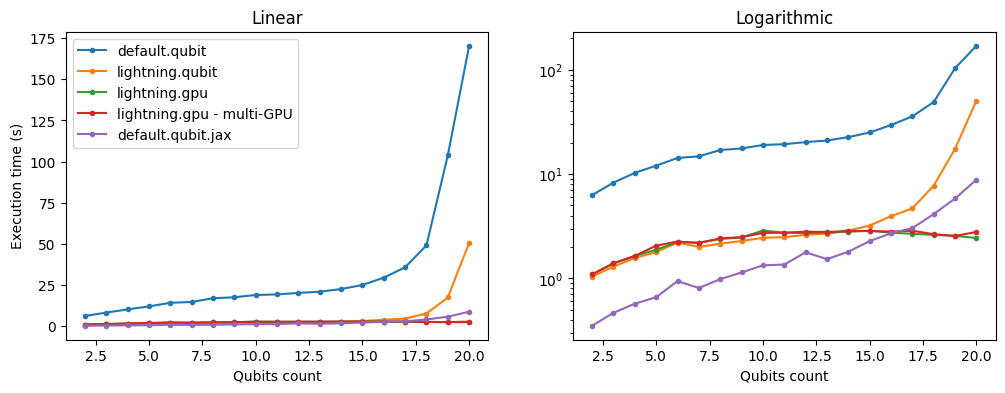

In [25]:
# 1 Filter

plt.style.use('default')

experiments = np.load('experiments/a100_jax_experiments_1_filter.npy', 
                      allow_pickle=True).item()

execution_times = aggregate_execution_times(experiments)

plot_time_per_qubit_counts(execution_times)

As it is seen above - `lightning.gpu` device is the most efficient for filters bigger then 18 qubits.

While `default.qubit.jax` is very useful for smaller filter sizes - which lead to bigger numer of filter applications and vectorization benefits.

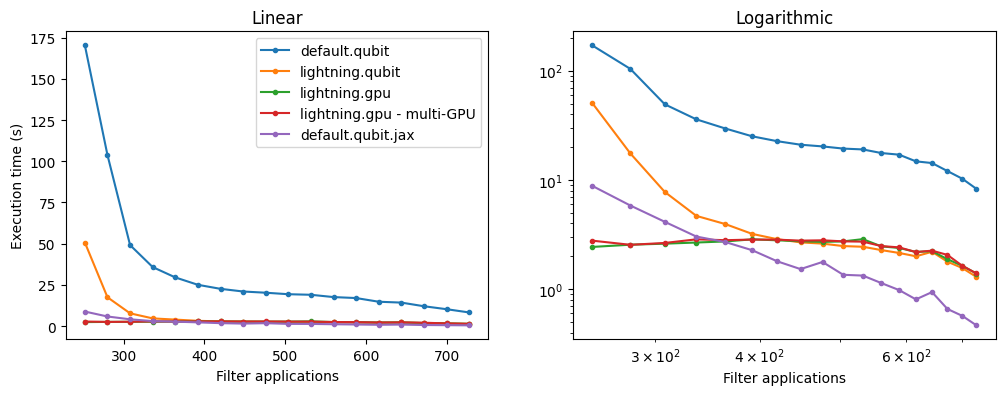

In [ ]:
plot_time_per_filter_applications(execution_times)

Situation becomes even more favorable for `default.qubit.jax` with increase in number of filters.

In below example - 8 filters are parallelized over 8 DGX-2 GPU cards - which makes `default.qubit.jax` faster then `lightning.gpu` even for 20 qubit filters.

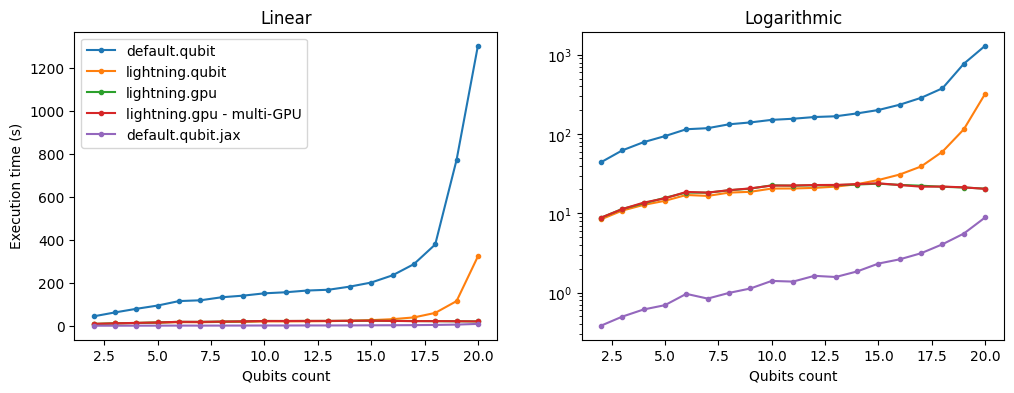

In [28]:
# 8 Filters

experiments = np.load('experiments/a100_jax_experiments_8_filters.npy', 
                      allow_pickle=True).item()

execution_times = aggregate_execution_times(experiments)

plot_time_per_qubit_counts(execution_times)

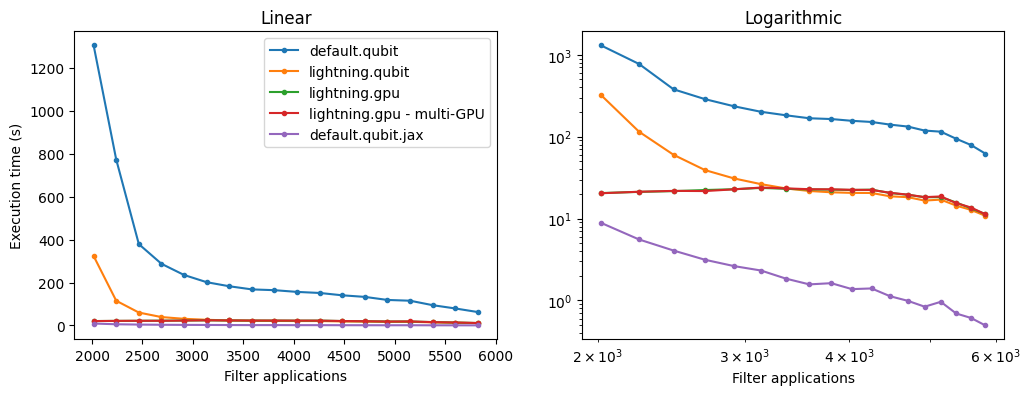

In [29]:
plot_time_per_filter_applications(execution_times)